In [1]:
from __future__ import division #NOTE: this prevent errors warning GPU0 <> GPU1 (GPU1 has < 75% capacity of GPU0)
import numpy as np
import pickle
import cv2
import imp

import torch as t
import torchvision as tv
import torchvision.transforms as transform
#from torch.utils.data import Dataset, DataLoader

import header_headoren_salcorr as header
import header_saliency_ds as header_sal
imp.reload(header_sal)
imp.reload(header)

from matplotlib import pyplot as plt
%matplotlib inline

use_cuda = t.cuda.is_available()
device = t.device("cuda:0" if use_cuda else "cpu")

H_SAL = 90
W_SAL = 160

del H_SAL
del W_SAL


def modify_fc_layers_obsoleted(model):
    #TODO: change default resnet: avgpool (3, 3), fc (2048 x 3 x 3) --> 90x160
    model.avgpool = t.nn.AdaptiveAvgPool2d(3)
    model.fc = t.nn.Linear(3 * 3 * 2048, H_SAL*W_SAL) # assuming that the fc7 layer has 512 neurons, otherwise change it 
    
def modify_fc_layers(model):
    model.avgpool = t.nn.AdaptiveAvgPool2d(3)
    model.fc = t.nn.Linear(3 * 3 * 2048, header_sal.TARGET_SAL_H*header_sal.TARGET_SAL_W) # assuming that the fc7 layer has 512 neurons, otherwise change it 
    
    
class PanoSalDataset(t.utils.data.Dataset):
    def __init__(self, pickle_file, transform=None):
        self._pickle_file = pickle_file
        self._dat = pickle.load(open(pickle_file, 'rb'))
    
    def __len__(self):
        return len(self._dat)
    
    def __getitem__(self, idx):
        if t.is_tensor(idx):
            idx = idx.tolist()
        t0, img, smap = self._dat[idx]
        #print (f'Before: {img.shape}')
        img = img.transpose((2, 0, 1))
        #print (f'After: {img.shape}')
        return t0, img, smap
    

In [2]:
#NOTE: this step is only done ONCE to convert pretrained saliency 144x256 to saliency 45x80
#after the converion, the model will be save, this code will be commented out
# PATH = './models/panoresnet152_step002_891'
# resnet = tv.models.resnet152(pretrained=True)
# modify_fc_layers(resnet)
# resnet.load_state_dict(t.load(PATH, map_location=device))
# modify_fc_layers_v2(resnet)
# t.save(resnet.state_dict(), './models/panoresnet152_sal45x80_step002_epoch0')


In [3]:

resnet = tv.models.resnet101(pretrained=True)
modify_fc_layers(resnet)
resnet.to(device)
PATH = '../hmd-observe-video-prediction/models/panoresnet152_sal45x80merged_step002_90'
resnet.load_state_dict(t.load(PATH, map_location=device))

<All keys matched successfully>

In [4]:
ls -a ../hmd-observe-video-prediction/models/panoresnet152_sal45x80merged_step002_90

../hmd-observe-video-prediction/models/panoresnet152_sal45x80merged_step002_90


In [5]:
1+1

2

In [6]:
sal_ds_filepath = '../hmd-observe-video-prediction/data/pano-saliency-merge/ds_dcnn_step0.2'
#sal_ds_filepath = './dataset/pano-saliency/ds_full'
tf5 =  transform.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
transformed_dataset = PanoSalDataset(sal_ds_filepath, transform=tv.transforms.Compose([tv.transforms.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.2, hue=0.1), tv.transforms.ToTensor(), tf5]))
trainloader = t.utils.data.DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=4)


In [7]:
resnet.avgpool, resnet.fc

(AdaptiveAvgPool2d(output_size=3),
 Linear(in_features=18432, out_features=3600, bias=True))

In [10]:
learning_rate = 3e-4
optim = t.optim.Adam(resnet.parameters(), lr=learning_rate, weight_decay=1e-6)
loss_log = []

In [11]:
def get_lr(optimizer):#directly change learning rate of the optimizer
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
import timeit

N_EPOCH = 900
N_REPORT = 200


btime = timeit.default_timer()
for epoch in range(N_EPOCH):
    running_loss = 0.
    for i, (t0, img_list, label_list) in enumerate(trainloader):
        start = t.cuda.Event(enable_timing=True)
        end = t.cuda.Event(enable_timing=True)
        start.record() ###measure training time for one iteration
        img_list = img_list.type(t.FloatTensor).to(device)
        label_list = label_list.type(t.FloatTensor).to(device)
        optim.zero_grad()
        fx = resnet(img_list)
        #print (fx.shape)
        fx = fx.view(-1, header_sal.TARGET_SAL_H, header_sal.TARGET_SAL_W)
        #loss = t.nn.functional.mse_loss(fx, label_list)
        loss = t.norm(fx - label_list, 2)
        loss.backward()#now backward, grad in graph will have something
        optim.step()#now, the weights is update.
        
        running_loss += loss.item()
        if i % N_REPORT == N_REPORT-1:    # print every N_REPORT mini-batches
            end.record()
            t.cuda.synchronize()
            
            print ('iter time: {}, exec time: {}, cur learning rate: {}'.format(start.elapsed_time(end), timeit.default_timer() - btime, get_lr(optim)))
            btime = timeit.default_timer()
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / N_REPORT))
            loss_log.append(running_loss/N_REPORT)
            running_loss = 0.0
            
            
    #eval_accuracy(yolo, pred, testloader, device, threshold=0.5)
    if epoch % 30 ==0 and epoch > 1:
                t.save(resnet.state_dict(), '../hmd-observe-video-prediction/models/panoresnet101_sal45x80merged_step002_{}'.format(epoch))
                #eval_accuracy(yolo, pred, testloader, device, threshold=0.5)

iter time: 82.03033447265625, exec time: 17.000593870994635, cur learning rate: 0.0003
[1,   200] loss: 2.680
iter time: 82.56511688232422, exec time: 16.771254819002934, cur learning rate: 0.0003
[1,   400] loss: 2.573
iter time: 82.55677032470703, exec time: 16.809091644943692, cur learning rate: 0.0003
[1,   600] loss: 2.563
iter time: 87.578369140625, exec time: 17.52847365301568, cur learning rate: 0.0003
[1,   800] loss: 2.485
iter time: 87.2616958618164, exec time: 17.857320268056355, cur learning rate: 0.0003
[1,  1000] loss: 2.446
iter time: 87.69229125976562, exec time: 17.867260967963375, cur learning rate: 0.0003
[1,  1200] loss: 2.489
iter time: 87.70626831054688, exec time: 17.894867003895342, cur learning rate: 0.0003
[1,  1400] loss: 2.416
iter time: 87.87561798095703, exec time: 33.389477466000244, cur learning rate: 0.0003
[2,   200] loss: 2.117
iter time: 87.52521514892578, exec time: 17.932925192988478, cur learning rate: 0.0003
[2,   400] loss: 2.176
iter time: 88.

iter time: 84.77471923828125, exec time: 16.74928737198934, cur learning rate: 0.0003
[11,  1200] loss: 1.291
iter time: 82.01827239990234, exec time: 17.894057458965108, cur learning rate: 0.0003
[11,  1400] loss: 1.242
iter time: 82.48480224609375, exec time: 31.17804020503536, cur learning rate: 0.0003
[12,   200] loss: 1.081
iter time: 82.02518463134766, exec time: 16.702492590993643, cur learning rate: 0.0003
[12,   400] loss: 1.146
iter time: 82.00028991699219, exec time: 16.68678257893771, cur learning rate: 0.0003
[12,   600] loss: 1.127
iter time: 82.08726501464844, exec time: 16.675218318938278, cur learning rate: 0.0003
[12,   800] loss: 1.146
iter time: 81.92320251464844, exec time: 16.687702264986, cur learning rate: 0.0003
[12,  1000] loss: 1.197
iter time: 82.08303833007812, exec time: 16.674287806032225, cur learning rate: 0.0003
[12,  1200] loss: 1.208
iter time: 81.93465423583984, exec time: 16.759289109962992, cur learning rate: 0.0003
[12,  1400] loss: 1.200
iter ti

iter time: 82.19910430908203, exec time: 16.694057254004292, cur learning rate: 0.0003
[22,   800] loss: 0.943
iter time: 82.12659454345703, exec time: 16.694958330946974, cur learning rate: 0.0003
[22,  1000] loss: 0.960
iter time: 82.42591857910156, exec time: 16.769695946015418, cur learning rate: 0.0003
[22,  1200] loss: 0.959
iter time: 83.33859252929688, exec time: 17.106905972003005, cur learning rate: 0.0003
[22,  1400] loss: 0.960
iter time: 90.55427551269531, exec time: 33.0853772519622, cur learning rate: 0.0003
[23,   200] loss: 0.916
iter time: 85.2465591430664, exec time: 17.885926181916147, cur learning rate: 0.0003
[23,   400] loss: 0.906
iter time: 86.63021087646484, exec time: 17.741594283026643, cur learning rate: 0.0003
[23,   600] loss: 0.960
iter time: 91.52787017822266, exec time: 17.665407111053355, cur learning rate: 0.0003
[23,   800] loss: 0.948
iter time: 89.28189086914062, exec time: 18.252785605029203, cur learning rate: 0.0003
[23,  1000] loss: 0.943
iter

iter time: 87.72041320800781, exec time: 17.90370049199555, cur learning rate: 0.0003
[33,   400] loss: 0.832
iter time: 90.87459564208984, exec time: 17.9649626230821, cur learning rate: 0.0003
[33,   600] loss: 0.844
iter time: 89.80255889892578, exec time: 18.208543948014267, cur learning rate: 0.0003
[33,   800] loss: 0.838
iter time: 81.92819213867188, exec time: 17.209212122950703, cur learning rate: 0.0003
[33,  1000] loss: 0.839
iter time: 81.85212707519531, exec time: 16.643574096029624, cur learning rate: 0.0003
[33,  1200] loss: 0.881
iter time: 81.9804458618164, exec time: 16.644358705030754, cur learning rate: 0.0003
[33,  1400] loss: 0.863
iter time: 83.30284881591797, exec time: 31.213368398020975, cur learning rate: 0.0003
[34,   200] loss: 0.843
iter time: 88.5027847290039, exec time: 17.88943875604309, cur learning rate: 0.0003
[34,   400] loss: 0.810
iter time: 89.7873306274414, exec time: 18.12425762496423, cur learning rate: 0.0003
[34,   600] loss: 0.832
iter time

KeyboardInterrupt: 

In [ ]:
#t.save(resnet.state_dict(), '../hmd-observe-video-prediction/models/panoresnet101_sal45x80merged_step002_{}'.format(epoch))
#NOTE: current training is at 384 including 5part1 but accuracy is very low, more than 384 is previous run, not including 5part1
#try at 200

In [ ]:
plt.plot(loss_log)
plt.title(f'epoch={epoch}')

In [8]:
1+1

2

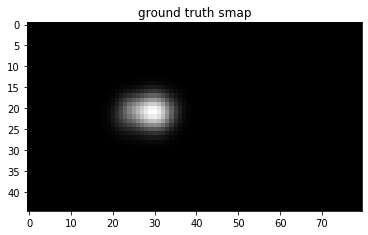

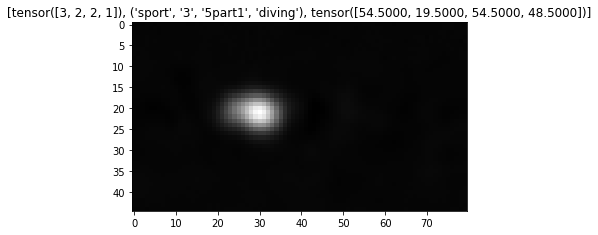

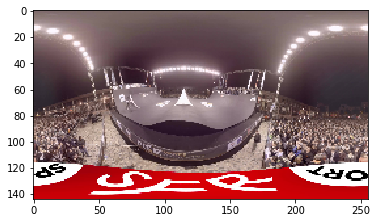

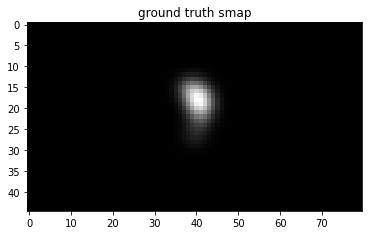

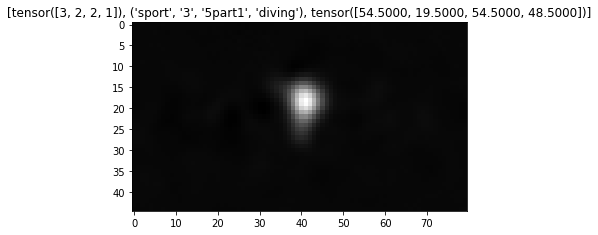

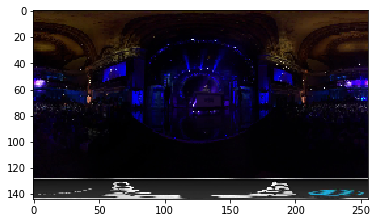

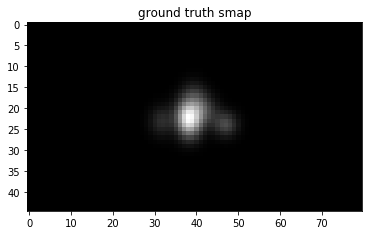

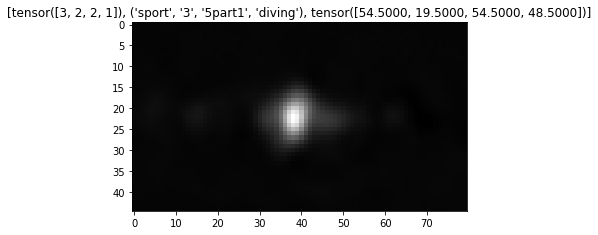

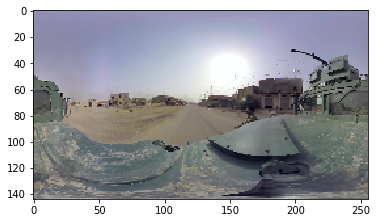

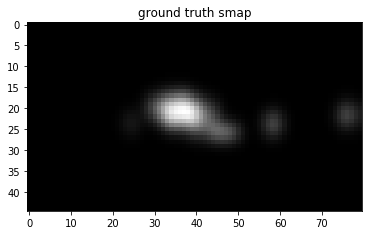

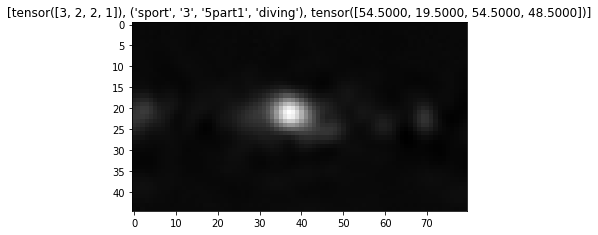

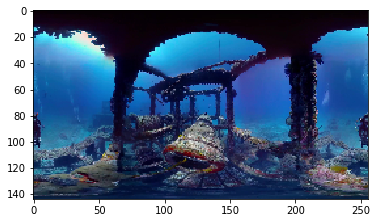

<Figure size 432x288 with 0 Axes>

In [15]:

sal_test_filepath = '../hmd-observe-video-prediction/data/pano-saliency-merge/ds_dcnn_test'
#sal_ds_filepath = './dataset/pano-saliency/ds_full'
tf5 =  transform.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
test_transformed_dataset = PanoSalDataset(sal_test_filepath, transform=tv.transforms.Compose([tv.transforms.ToTensor(), tf5]))
testloader = t.utils.data.DataLoader(test_transformed_dataset, batch_size=4, shuffle=True, num_workers=4)

with t.no_grad():
    for i, (t0, img_list, label_list) in enumerate(testloader):
        for idx in range(4):
            img_list = img_list.type(t.FloatTensor).to(device)
            fx = resnet(img_list).view(-1, header_sal.TARGET_SAL_H, header_sal.TARGET_SAL_W)
            smap = fx[idx].data.cpu().numpy()
            
            img = img_list[idx].data.cpu().numpy().transpose(1, 2, 0).astype(int)
            label = label_list[idx].data.cpu().numpy()
            plt.imshow(label, cmap='gray')
            plt.title('ground truth smap')
            plt.figure()
            plt.imshow(smap, cmap='gray')
            plt.title('predicted smap')
            plt.title(t0)
            plt.figure()    
            plt.imshow(img)
            plt.figure()
        break

In [20]:
1+1

2

In [41]:
#STEP2: from the model, generate saliency map for all video
#get all timestamp for all saliency_ds{}_topic{}
#generate saliency for given timestamp
#save as named saliency_ds{}_topic_{} in the pano-saliency-predicted folder

In [ ]:
#TODO: load the ds_full file, makes all prediction, write back into file

In [28]:
pwd

'/home/anh2/workspace/PanoSaliencyModel'

In [16]:
dat = pickle.load(open('../hmd-observe-video-prediction/data/pano-saliency-merge/ds_dcnn_expdistance_full', 'rb'))


In [17]:
#TODO: Predict salency for ALL image from ALL videos
#input: file ds_full, containing the groundtruth saliency & the images
#output: a dict containting timestmap & predicted saliency for ALL videos

tdict = header.topic_dict
tf_list = tv.transforms.Compose([tv.transforms.ToTensor(), tf5])
salpred_dict = {1:{}, 2:{}, 3:{}}
with t.no_grad():
    for (ds, topic, t0), img, smap in dat:
            #print (f'generating predicted saliency for ds={ds} topic={topic}')
            x = tf_list(img).unsqueeze(0).to(device)
            fx = resnet(x)
            fx = fx.data.cpu().view(header_sal.TARGET_SAL_H, header_sal.TARGET_SAL_W).numpy()
            #fx = cv2.resize(fx, (header.TARGET_STANDARD_SAL_W, header.TARGET_STANDARD_SAL_H))
            if topic not in salpred_dict[ds]:
                salpred_dict[ds][topic] = []
            salpred_dict[ds][topic].append((t0, -1, fx))
#             plt.imshow(fx.data.cpu().view(H_SAL, W_SAL))
#             plt.figure()
#             plt.imshow(img)
#             plt.title(f'{ds}-{topic}-{t0}')
#             plt.figure()
#             plt.imshow(smap, cmap='gray')
#             plt.figure()


In [18]:
#now, write down the predicted saliency into files
#panoresnet101_step005_810
for ds in tdict:
    for topic in tdict[ds]:
        print (f'Writting predicted saliency for ds:{ds} - topic:{topic} to file')
        filepath_name = f'../hmd-observe-video-prediction/data/-expdistance/saliency_ds{ds}_topic{topic}'
        pickle.dump(salpred_dict[ds][topic], open(filepath_name, 'wb'))

Writting predicted saliency for ds:1 - topic:paris to file
Writting predicted saliency for ds:1 - topic:roller to file
Writting predicted saliency for ds:1 - topic:venise to file
Writting predicted saliency for ds:1 - topic:diving to file
Writting predicted saliency for ds:1 - topic:timelapse to file
Writting predicted saliency for ds:2 - topic:0 to file
Writting predicted saliency for ds:2 - topic:1 to file
Writting predicted saliency for ds:2 - topic:2 to file
Writting predicted saliency for ds:2 - topic:3 to file
Writting predicted saliency for ds:2 - topic:4 to file
Writting predicted saliency for ds:2 - topic:5part1 to file
Writting predicted saliency for ds:2 - topic:6part1 to file
Writting predicted saliency for ds:2 - topic:7 to file
Writting predicted saliency for ds:2 - topic:8 to file
Writting predicted saliency for ds:3 - topic:coaster2 to file
Writting predicted saliency for ds:3 - topic:diving2 to file
Writting predicted saliency for ds:3 - topic:drive to file
Writting pr

In [32]:
1+1

2

In [2]:
#STEP2: train saliency predictor
import numpy as np
import pickle
import cv2
import imp

import torch as t
import torchvision as tv
import torchvision.transforms as transform
#from torch.utils.data import Dataset, DataLoader

import saliency_predictor
import header_headoren_salcorr as header
import header_saliency_ds as header_sal
imp.reload(header_sal)
imp.reload(header)

from matplotlib import pyplot as plt
%matplotlib inline

use_cuda = t.cuda.is_available()
device = t.device("cuda:1" if use_cuda else "cpu")

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1., p=0.5):
        self.std = std
        self.mean = mean
        self.p = p
        
    def __call__(self, tensor):
        if np.random.rand() > self.p:
            return tensor
        return tensor + t.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


In [3]:
sal_ds_filepath = '../hmd-observe-video-prediction/data/pano-saliency-merge/ds_dcnn_expdistance_step0.1'
#sal_ds_filepath = '../hmd-observe-video-prediction/data/pano-saliency-merge/ds_dcnn_expdistance_full'
#sal_ds_filepath = './dataset/pano-saliency/ds_full'
tf5 =  transform.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
#tv.transforms.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.2, hue=0.1)
transform_train = [tv.transforms.ToTensor(), tf5]
transform_test  = [tv.transforms.ToTensor(), tf5]
transform_gen   = [tv.transforms.ToTensor(), tf5]
transformed_dataset = saliency_predictor.PanoSalDataset(sal_ds_filepath, transform=tv.transforms.Compose(transform_train))
trainloader = t.utils.data.DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=4)

In [9]:
for i, (t0, img_list, label_list) in enumerate(trainloader):
    print (label_list.mean(),label_list.min(), label_list.max())
    if i > 10:
        break

tensor(0.0163, dtype=torch.float64) tensor(6.1999e-120, dtype=torch.float64) tensor(0.8131, dtype=torch.float64)
tensor(0.0198, dtype=torch.float64) tensor(6.5496e-163, dtype=torch.float64) tensor(0.8593, dtype=torch.float64)
tensor(0.0242, dtype=torch.float64) tensor(2.8755e-164, dtype=torch.float64) tensor(0.8774, dtype=torch.float64)
tensor(0.0214, dtype=torch.float64) tensor(9.7419e-85, dtype=torch.float64) tensor(0.8043, dtype=torch.float64)
tensor(0.0204, dtype=torch.float64) tensor(1.6279e-85, dtype=torch.float64) tensor(0.8259, dtype=torch.float64)
tensor(0.0166, dtype=torch.float64) tensor(9.6944e-199, dtype=torch.float64) tensor(0.8624, dtype=torch.float64)
tensor(0.0218, dtype=torch.float64) tensor(2.1720e-157, dtype=torch.float64) tensor(0.8360, dtype=torch.float64)
tensor(0.0170, dtype=torch.float64) tensor(5.5556e-191, dtype=torch.float64) tensor(0.8892, dtype=torch.float64)
tensor(0.0307, dtype=torch.float64) tensor(8.1917e-162, dtype=torch.float64) tensor(0.8549, dtype=